In [1]:
%load_ext autoreload
%autoreload 2

# Inverse problem for the diffusion-reaction system

Benchmark on the Inverse problem for the diffusion-reaction system as proposed in DeepXDE documentation: https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/reaction.inverse.html.


In [2]:
seed = 1

In [3]:
import numpy as np

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 2000
DEFAULT_NUM_BOUNDARY_POINTS = 100
DEFAULT_NUM_INITIAL_POINTS = 100

def gen_traindata(lib):
    data = np.load("reaction.npz")
    t, x, ca, cb = data["t"], data["x"], data["Ca"], data["Cb"]
    X, T = np.meshgrid(x, t)
    X = np.reshape(X, (-1, 1))
    T = np.reshape(T, (-1, 1))
    Ca = np.reshape(ca, (-1, 1))
    Cb = np.reshape(cb, (-1, 1))
    if lib == "dde":
        return np.hstack((X, T)), Ca, Cb
    if lib == "jinns":
        return np.hstack((T, X)), np.hstack((Ca, Cb))
    if lib == "pina":
        return np.hstack((T, X)), np.hstack((Ca, Cb))

kf_init = 0.05
D_init = 1.

**Summary:**
- [DeepXDE](#DeepXDE)
- [jinns](#jinns)
- [PINA](#PINA)
- [Comparisons](#Comparisons)

## DeepXDE


We use the tensorflow backend as JAX backend is not available

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.905477 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.21e-03, 1.85e-02, 3.20e-01, 3.27e-01, 2.98e-02, 3.95e-02, 6.13e-02, 2.67e-01]    [3.04e-03, 1.76e-02, 3.20e-01, 3.27e-01, 2.98e-02, 3.95e-02, 6.13e-02, 2.67e-01]    []  
1000      [1.17e-04, 1.74e-04, 3.47e-04, 3.59e-04, 7.37e-04, 9.50e-04, 3.76e-04, 1.57e-04]    [9.84e-05, 1.32e-04, 3.47e-04, 3.59e-04, 7.37e-04, 9.50e-04, 3.76e-04, 1.57e-04]    []  
2000      [6.18e-05, 4.95e-05, 3.93e-05, 5.88e-05, 9.65e-05, 1.60e-04, 2.14e-05, 4.48e-05]    [5.39e-05, 3.77e-05, 3.93e-05, 5.88e-05, 9.65e-05, 1.60e-04, 2.14e-05, 4.48e-05]    []  
3000      [5.97e-05, 4.57e-05, 2.19e-05, 2.84e-05, 3.44e-05, 6.09e-05, 1.49e-05, 3.84e-05]    [4.81e-05, 3.61e-05, 2.19e-05, 2.84e-05, 3.44e-05, 6.09e-05, 1.49e-05, 3.84e-05]    []  
4000      [5.

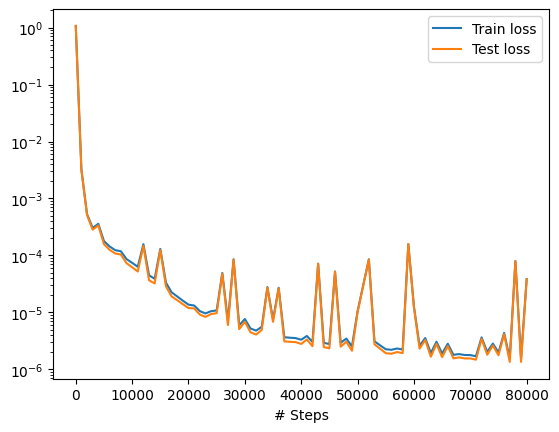

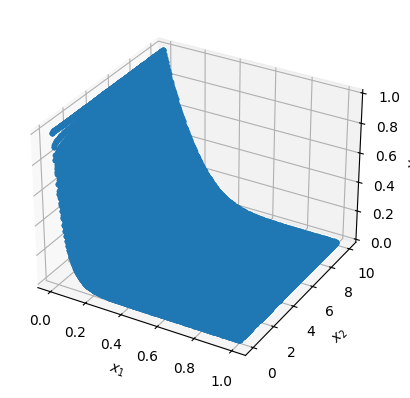

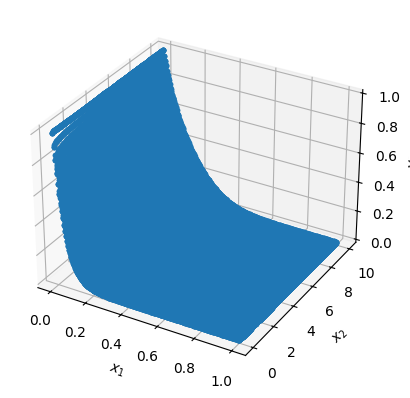

In [4]:
import os
os.environ["DDE_BACKEND"]="pytorch"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)

kf = dde.Variable(kf_init)
D = dde.Variable(D_init)

# PDE for Pytorch
def pde(x, y):
    ca, cb = y[:, 0:1], y[:, 1:2]
    dca_t = dde.grad.jacobian(y, x, i=0, j=1)
    dca_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dcb_t = dde.grad.jacobian(y, x, i=1, j=1)
    dcb_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    eq_a = dca_t - 1e-3 * D * dca_xx + kf * ca * cb ** 2
    eq_b = dcb_t - 1e-3 * D * dcb_xx + 2 * kf * ca * cb ** 2
    return [eq_a, eq_b]


def fun_bc(x):
    return 1 - x[:, 0:1]


def fun_init(x):
    return np.exp(-20 * x[:, 0:1])


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc_a = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=0
)
bc_b = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
)
ic1 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)
ic2 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=1)

observe_x, Ca, Cb = gen_traindata(lib="dde")
observe_y1 = dde.icbc.PointSetBC(observe_x, Ca, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, Cb, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_a, bc_b, ic1, ic2, observe_y1, observe_y2],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    num_initial=DEFAULT_NUM_INITIAL_POINTS,
    anchors=observe_x,
    # num_test=50000,
)
net = dde.nn.FNN([2] + [20] * 3 + [2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[kf, D])
variable = dde.callbacks.VariableValue([kf, D], period=1000, filename="variables.dat")
losshistory, train_state = model.train(iterations=80000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## jinns

In [5]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [6]:
eqx_list = (
    (eqx.nn.Linear, 2, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 2)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [7]:
n = DEFAULT_NUM_DOMAIN_POINTS
ni = DEFAULT_NUM_INITIAL_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 1
xmin = 0
xmax = 1
tmin = 0
tmax = 10
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [8]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "D":jnp.array(D_init),
        "kf":jnp.array(kf_init)
    }
)

In [9]:
from jinns.loss import PDENonStatio

class DiffusionReaction(PDENonStatio):
    def equation(self, t_x, u, params):
        Ca = u(t_x, params)[0]
        Cb = u(t_x, params)[1]

        dC_dt = jax.jacrev(u)(t_x, params)[:, 0]
    
        lap = jinns.loss.vectorial_laplacian_rev(t_x, u, params, dim_out=2)
        return (dC_dt - params.eq_params["D"] * lap
                + jnp.array([params.eq_params["kf"] * Ca * Cb ** 2,
                             2 * params.eq_params["kf"] * Ca * Cb ** 2
                            ])
               )

dr_loss = DiffusionReaction()

In [10]:
def u0(x):
    init = jnp.exp(-20 * x)
    return jnp.array([init, init])

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1, boundary_loss=1, observations=1
)

In [11]:
key, subkey = jax.random.split(key)
observe_t_x, Ca_Cb = gen_traindata(lib="jinns")

obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=observe_t_x,
    observed_values=Ca_Cb
)

In [12]:
derivative_keys = jinns.parameters.DerivativeKeysPDENonStatio.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params = True,
        eq_params = {
            'kf':True,
            'D':True
        }
    ),
    boundary_loss="nn_params",
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params_pinn
)

In [13]:
loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=dr_loss,
    derivative_keys=derivative_keys,
    omega_boundary_fun={"xmin":lambda t_dx: jnp.array([1, 1]),
                        "xmax": lambda t_dx: jnp.array([0, 0])
                       },
    omega_boundary_condition={"xmin":"dirichlet","xmax":"dirichlet"},
    initial_condition_fun=u0,
    params=init_params_pinn,
)

In [14]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 80000

In [15]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, stored_params, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    obs_data=obs_data,
    tracked_params = jinns.parameters.Params(
        eq_params={"D":True, "kf":True}
    ),
    verbose=True
)


Compilation took
 5.491732120513916 

[train] Iteration 0: loss value = 2.6183230876922607
[train] Iteration 1000: loss value = 0.012219011783599854
[train] Iteration 2000: loss value = 0.0004975139163434505
[train] Iteration 3000: loss value = 0.00031472009140998125
[train] Iteration 4000: loss value = 0.00024010107154026628
[train] Iteration 5000: loss value = 0.00027583292103372514
[train] Iteration 6000: loss value = 0.00015940274170134217
[train] Iteration 7000: loss value = 0.00014110884512774646
[train] Iteration 8000: loss value = 0.00012670607247855514
[train] Iteration 9000: loss value = 0.00011282250488875434
[train] Iteration 10000: loss value = 9.997902088798583e-05
[train] Iteration 11000: loss value = 8.832546882331371e-05
[train] Iteration 12000: loss value = 7.844361243769526e-05
[train] Iteration 13000: loss value = 7.007845852058381e-05
[train] Iteration 14000: loss value = 6.31362127023749e-05
[train] Iteration 15000: loss value = 5.73931320104748e-05
[train] Itera

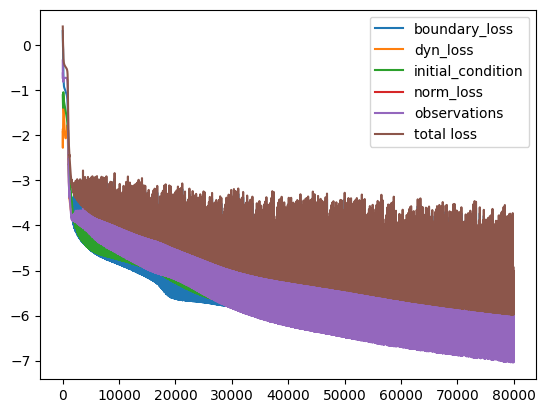

In [16]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

## PINA

In [19]:
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import torch
from pytorch_lightning.callbacks import Callback
from pina.problem import SpatialProblem, InverseProblem, TimeDependentProblem
from pina.operators import grad, div
from pina.model import FeedForward
from pina.equation import Equation, FixedValue, SystemEquation
from pina import Condition, Trainer, LabelTensor
from pina.solvers import PINN
from pina.geometry import CartesianDomain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
observe_x, CaCb = gen_traindata(lib="pina")

observe_x = LabelTensor(torch.from_numpy(observe_x).float(), labels=['t', 'x'])
CaCb = LabelTensor(torch.from_numpy(CaCb).float(),
                 labels=['Ca', 'Cb'])


class DiffusionReaction(TimeDependentProblem, SpatialProblem,  InverseProblem):

    output_variables = ['Ca', 'Cb']

    spatial_domain = CartesianDomain({'x': [0, 1]})
    temporal_domain = CartesianDomain({'t': [0, 10]})
    unknown_parameter_domain = CartesianDomain({'D': [-3, 3], 'kf': [-3, 3]})

    def diffusion_reaction_Ca(input_, output_, params_):
        dCa_dt = grad(output_, input_, components=['Ca'], d=['t'])
        d2Ca_dx2 = grad(
            grad(output_, input_, components=['Ca'], d=['x']),
            input_,
            components=['dCadx'], # this label is automatically given to the output of the inner grad
            d=['x']
        )
        return (dCa_dt - params_["D"] * d2Ca_dx2
            + params_["kf"] * output_.extract('Ca') * output_.extract('Cb') ** 2)

    def diffusion_reaction_Cb(input_, output_, params_):
        dCb_dt = grad(output_, input_, components=['Cb'], d=['t'])
        d2Cb_dx2 = grad(
            grad(output_, input_, components=['Cb'], d=['x']),
            input_,
            components=['dCbdx'], # this label is automatically given to the output of the inner grad
            d=['x']
        )
        return (dCb_dt - params_["D"] * d2Cb_dx2
            + 2 * params_["kf"] * output_.extract('Ca') * output_.extract('Cb') ** 2)

    def initial_condition(input_, output_, params_):
        CaCb_expected = torch.exp(-20 * input_)
        return output_ - CaCb_expected


    # define the conditions for the loss (boundary conditions, equation, data)
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': 0, 't': [0, 10]}),
                            equation=FixedValue(1.)),
        'gamma2': Condition(location=CartesianDomain({'x': 1, 't': [0, 10]}),
                            equation=FixedValue(0.)),
        't0': Condition(location=CartesianDomain({'x': [0, 1], 't': 0}),
                        equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [0, 1], 't': [0, 10]}),
                        equation=SystemEquation([diffusion_reaction_Ca, diffusion_reaction_Cb])),
        'data': Condition(
            input_points=observe_x,
            output_points=CaCb
        ),
    }

problem = DiffusionReaction()

In [21]:
from math import sqrt

problem.discretise_domain(
    n=int(sqrt(DEFAULT_NUM_DOMAIN_POINTS)), # NOTE the sqrt
    mode='grid',
    variables=['x', 't'],
    locations='D'
)
problem.discretise_domain(
    n=DEFAULT_NUM_BOUNDARY_POINTS // 2, # divide by 2 since NUM_BOUNDARY is the total
    mode='grid',
    variables=['x', 't'],
    locations=['gamma1', 'gamma2']
)
problem.discretise_domain(
    n=DEFAULT_NUM_INITIAL_POINTS,
    mode='grid',
    variables=['x', 't'],
    locations=['t0']
)
print('Input points:', problem.input_pts['D'].shape)
print('Input points:', problem.input_pts['gamma2'].shape)
print('Input points:', problem.input_pts['gamma1'].shape)
print('Input points:', problem.input_pts['t0'].shape)

Input points: torch.Size([1936, 2])
Input points: torch.Size([50, 2])
Input points: torch.Size([50, 2])
Input points: torch.Size([100, 2])


In [22]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker, PINAProgressBar
from pytorch_lightning.callbacks import Timer

# temporary directory for saving logs of training
tmp_dir = "tmp_pina"

class SaveParameters(Callback):
    '''
    Callback to save the parameters of the model every 1000 epochs.
    '''
    def on_train_epoch_end(self, trainer, __):
        if trainer.current_epoch % 1000 == 999:
            torch.save(trainer.solver.problem.unknown_parameters, '{}/parameters_epoch{}'.format(tmp_dir, trainer.current_epoch))
            
pbar = PINAProgressBar(metrics=['mean'], refresh_rate=1)

# build the model
model_ = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# create the PINN object
pinn = PINN(
    problem,
    model_,
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3}
)

# create the trainer
trainer = Trainer(
    solver=pinn,
    max_epochs=80000,
    callbacks=[MetricTracker(), pbar, SaveParameters(), Timer()],
    accelerator='gpu',
    enable_model_summary=False,
    log_every_n_steps=1000,
    val_check_interval=1000,
    check_val_every_n_epoch=None,
    enable_checkpointing=False,
    default_root_dir=tmp_dir
) 

# train
trainer.train()

print(f'Total training time {trainer.callbacks[-1].time_elapsed("train"):.5f} s')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=1000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80000` reached.


Total training time 4061.76818 s


/tmp/ipykernel_134475/2684776785.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params_torch = torch.load('{}/parameters_epoch{}'.format(tmp_dir, epoch))


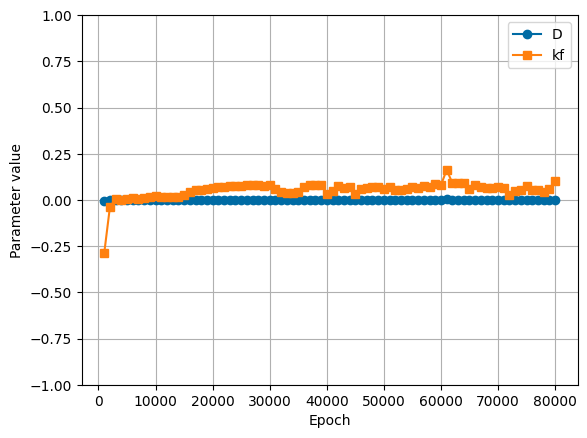

In [24]:
max_epochs = 80000
epochs_saved = range(999, max_epochs, 1000)
parameters = torch.empty((int(max_epochs/1000), 2))
for i, epoch in enumerate(epochs_saved):
    params_torch = torch.load('{}/parameters_epoch{}'.format(tmp_dir, epoch))
    for e, var in enumerate(pinn.problem.unknown_variables):
        parameters[i, e] = params_torch[var].data

# Plot parameters
plt.close()
plt.plot(epochs_saved, parameters[:, 0], label='D', marker='o')
plt.plot(epochs_saved, parameters[:, 1], label='kf', marker='s')
plt.ylim(-1, 1)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Parameter value')
plt.show()

## Comparisons

In [26]:
print(f"{D_init=}, {kf_init=}")
D_true = 0.002
kf_true = 0.1
print(f"According to DeepXDE's doc, {D_true=} and {kf_true=}")

D_init=1.0, kf_init=0.05
According to DeepXDE's doc, D_true=0.002 and kf_true=0.1


In [18]:
import re
with open('variables.dat') as f:
    for line in f:
        pass
    last_line = line
kf_D = np.fromstring(
    min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), last_line), key=len),
    sep=",",
)
print("DeepXDE: estimated D=", kf_D[1],
      "l1re=", jnp.abs(kf_D[1] - D_true) / jnp.abs(D_true),
      "l2re=", jnp.sqrt((kf_D[1] - D_true) **2) / jnp.sqrt(D_true ** 2)
)
print("DeepXDE: estimated kf=", kf_D[0],
      "l1re=", jnp.abs(kf_D[0] - kf_true) / jnp.abs(kf_true),
      "l2re=", jnp.sqrt((kf_D[0] - kf_true) **2) / jnp.sqrt(kf_true ** 2)
)

DeepXDE: estimated D= 1.99 l1re= 993.99994 l2re= 994.0
DeepXDE: estimated kf= 0.0983 l1re= 0.017 l2re= 0.016999999


**$D$ needs to be rescaled by $1e-3$ (see DeepXDE's equation)**

In [20]:
print("jinns: estimated D=", stored_params.eq_params["D"][-1],
      "l1re=", jnp.abs(stored_params.eq_params["D"][-1] - D_true) / jnp.abs(D_true),
      "l2re=", jnp.sqrt((stored_params.eq_params["D"][-1] - D_true) **2) / jnp.sqrt(D_true ** 2)
)
print("jinns: estimated kf=", stored_params.eq_params["kf"][-1],
      "l1re=", jnp.abs(stored_params.eq_params["kf"][-1] - kf_true) / jnp.abs(kf_true),
      "l2re=", jnp.sqrt((stored_params.eq_params["kf"][-1] - kf_true) **2) / jnp.sqrt(kf_true ** 2)
)

jinns: estimated D= 0.0019661132 l1re= 0.016943434 l2re= 0.016943436
jinns: estimated kf= 0.098666705 l1re= 0.013332963 l2re= 0.013332963


In [27]:
D_pina = parameters[-1, 0]
kf_pina = parameters[-1, 1]
print("PINA: estimated D=", D_pina,
      "l1re=", np.abs(D_pina - D_true) / np.abs(D_true),
      "l2re=", np.sqrt((D_pina - D_true) **2) / np.sqrt(D_true ** 2)
)
print("PINA: estimated kf=", kf_pina,
      "l1re=", np.abs(kf_pina - kf_true) / np.abs(kf_true),
      "l2re=", np.sqrt((kf_pina - kf_true) **2) / np.sqrt(kf_true ** 2)
)

PINA: estimated D= tensor(0.0020) l1re= tensor(0.0235) l2re= tensor(0.0235)
PINA: estimated kf= tensor(0.1027) l1re= tensor(0.0275) l2re= tensor(0.0275)
